# TOI-1130 photoTRADES

In [1]:
import numpy as np
import os
import sys
# import glob
# import time as timer
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from pytransit import RoadRunnerModel
import matplotlib.pyplot as plt

/home/malavolta/CODE/others/anaconda3/envs/pyorbit_trades/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import `pytrades`

In [2]:
from pytrades import constants as cst
from pytrades import ancillary as anc
from pytrades import pytrades

Set `rcParams` with my default values

In [3]:
anc.set_rcParams()

Define input and output folders

In [4]:
here_folder = os.path.abspath(".")

photometry_folder = os.path.join(here_folder, "photometry")
# radial_velocities_folder = os.path.join(here_folder, "radial_velocities")
# transit_times_folder = os.path.join(here_folder, "transit_times")

out_folder = os.path.join(here_folder, "output")
os.makedirs(out_folder, exist_ok=True)

map_out_folder = os.path.join(out_folder, "01_map")
os.makedirs(map_out_folder, exist_ok=True)

## Photometry

### TESS

In [5]:
# tess_s13_file = os.path.join(
#     photometry_folder, 
#     "hlsp_qlp_tess_ffi_s0013-0000000254113311_tess_v01_llc.txt"
# )
# time_s13, flux_sap_s13, flux_sap_err_s13 = np.genfromtxt(tess_s13_file, delimiter=",", unpack=True)

tess_s13_file = os.path.join(
    photometry_folder, 
    "hlsp_qlp_tess_ffi_s0013-0000000254113311_tess_v01_llc.fits"
)
with fits.open(tess_s13_file) as hdul:
    print(hdul.info())
    s13_header = hdul[1].header
    tess_s13 = Table(hdul[1].data)

# print(s13_header)
texp = s13_header["TIMEDEL"]
print("exposure time = {:.6f}d == {:.0f}".format(texp, texp*cst.day2sec))
n_over = int(texp*cst.day2sec / 120.0)+1

Filename: /home/malavolta/CODE/PyORBIT/development/photodynamical/photometry/hlsp_qlp_tess_ffi_s0013-0000000254113311_tess_v01_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU     65   1320R x 13C   [D, J, E, E, E, J, J, E, E, E, E, E, E]   
None
exposure time = 0.020833d == 1800


In [6]:
# The input data is stored in tess_s13

#tess_s13

In [7]:
# We are associating the following variables to columns within the tess_s13 dataset
# As always, we are only interested in the Time, Flux and Fluxx error columns

time_s13, flux_sap_s13, flux_sap_err_s13 = tess_s13["TIME"], tess_s13["KSPSAP_FLUX"], tess_s13["KSPSAP_FLUX_ERR"]
quality = tess_s13["QUALITY"]
ok = np.logical_and(
    np.isnan(flux_sap_s13) == False,
    quality == 0
)
time_s13, flux_sap_s13, flux_sap_err_s13 = time_s13[ok], flux_sap_s13[ok], flux_sap_err_s13[ok]

In [8]:
fileout = open('photometry/tess_v01_llc_PyORBIT.dat', 'w')
for b, v, e in zip(time_s13, flux_sap_s13, flux_sap_err_s13 ):
    fileout.write('{0:16.8f} {1:12.8f} {2:12.8f} 0 -1 -1 \n'.format(b,v,e))
fileout.close()

In [9]:
# fig = plt.figure()

# plt.title("TESS-S13")
# plt.errorbar(
#     time_s13, flux_sap_s13,
#     yerr=flux_sap_err_s13,
#     color='black',
#     fmt='o',
#     ms=1.5,
#     ls='',
#     ecolor='gray',
#     elinewidth=0.4,
#     capsize=0
# )

# plt.show()
# plt.close(fig)

3 CHEOPS LCs AS TEST

In [10]:
# a transit of planet b
file_cheops = os.path.join(
    photometry_folder,
    "CHEOPS-PIPE_TOI-1130b_v04_CH_PR100031_TG042201_V0200_detrended.dat"
)
time_cheops_b, flux_cheops_b, flux_cheops_err_b = np.genfromtxt(file_cheops, usecols=(0,1,2), unpack=True)

In [11]:
# a transit of planet c
file_cheops = os.path.join(
    photometry_folder,
    "CHEOPS-PIPE_TOI-1130c_v03_CH_PR100015_TG018201_V0200_detrended.dat"
)
time_cheops_c, flux_cheops_c, flux_cheops_err_c = np.genfromtxt(file_cheops, usecols=(0,1,2), unpack=True)

In [12]:
# the transit of planet b and c
file_cheops = os.path.join(
    photometry_folder,
    "CHEOPS-PIPE_TOI-1130c_v06_CH_PR120053_TG004701_V0200_normalized.dat"
)
time_cheops_bc, flux_cheops_bc, flux_cheops_err_bc = np.genfromtxt(file_cheops, usecols=(0,1,2), unpack=True)

## Radial Velocities

### NONE

In [13]:
t_rv_obs = []

## Transit times

### NONE

## Set `pytrades` configuration

In [14]:
time_all = np.concatenate((time_s13, time_cheops_b, time_cheops_c, time_cheops_bc))
#time_all is just an array made up by "joinig" (concatenating) the "Time" arrays of each of the four data sets.

t_epoch = 1657.0 # I BELIEVE the t_epoch is the time at which we define our orbital parameters
t_start = np.min(time_all) - 10.0 # The start time of the simulation is just a little bit before the first (smallest) timestamp within the time_all array
# t_start = t_epoch
# t_end = Time("2023-08-30T00:00:00", format="isot", scale="tdb").jd - cst.btjd
t_end = np.max(time_all) + 1.0 # Finishing time is a little bit after the last (highest) timestamp in time_all
t_int = t_end - t_start

print("t_epoch = {}".format(t_epoch))
print("t_start = {}".format(t_start))
print("t_end   = {}".format(t_end))
print("total integration time: {} days".format(t_int))

body_names = ["star", "b", "c"]
n_body = len(
    body_names
)  # number of bodies (NOT PLANETS) in the system, that is star + planets

t_epoch = 1657.0
t_start = 1647.7246043610537
t_end   = 2752.82400874
total integration time: 1105.0994043789462 days


Let's define the system parameters

In [15]:
# These orbital parameters are defined at one specific instant. Is it at t_epoch?

M_msun = np.array(
    [0.745059, 19.833346 * cst.Mears, 335.603435 * cst.Mears]
)  # Masses in Solar unit
R_rsun = np.array(
    [0.697470, 3.657000 * cst.Rears, 12.983016 * cst.Rears]
)  # Radii in Solar unit
P_day = np.array([0.0, 4.074554, 8.350190])  # Periods in days
ecc_val = np.array([0.0, 0.0521624, 0.039773])  # eccentricities
argp_deg = np.array([0.0, 141.11112, 182.502357])  # argument of pericenters in degrees
mA_deg = np.array([0.0, 159.696701, 233.068994])  # mean anonalies in degrees
inc_deg = np.array([0.0, 87.494901, 87.613475])  # inclinations in degrees
lN_deg = np.array([0.0, 180.0, 179.993043])  # longitude of ascending nodes in degrees

### Within `photoTRADES` object/version ... skip it

In [16]:
# sim = pytrades.PhotoTRADES(
#     n_body,
#     t_epoch,
#     t_start,
#     t_int,
#     duration_check=1,
#     encounter_check=True,
#     do_hill_check=False,
#     amd_hill_check=False,
#     rv_res_gls=False,
# )

In [17]:
# sim.add_default_physical_parameters(
#     M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg
# )

Try the functions to simulate transit times, radial velocities, and photometry

Run the simulation as splitted in transit times + radial velocities ...

In [18]:
# (
#     time_steps,
#     orbits,
#     transits,
#     durations,
#     lambda_rm,
#     kep_elem,
#     body_flag,
#     rv_sim,
#     stable,
# ) = sim.orbital_parameters_to_transits(
#     M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg
# )

### `pytrades` simple version

Initialise `trades` only once

In [19]:
# Instead of calling the PhotoTRADES method, we're calling the args_init method with the same arguments

pytrades.args_init(
    n_body, # mandatory
    1, # duration_check # mandatory
    t_epoch=None, # not needed here
    t_start=None, # not needed here
    t_int=None, # not needed here
    encounter_check=True, # better alway True, we do not want close encounters!
    do_hill_check=False, # at will, as input option
    amd_hill_check=False, # at will, as input option
    rv_res_gls=False, # at will, as input option
)

Integrates and compute transit times, durations, etc. To be called within the log-likelihood

In [20]:
(
    time_steps,
    orbits,
    transits,
    durations,
    lambda_rm,
    kep_elem,
    body_flag,
    rv_sim, # {"time": array, "rv": array} the index will match the input t_rv_obs array
    stable,
) = pytrades.orbital_parameters_to_transits(
    t_epoch, t_start, t_int, M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg,
    t_rv_obs # this can be an empty list [] and it will ignore it, otherwise provide a list time at which compute RV
)

No issues not providing observed RV or Transit times

In [21]:
print(rv_sim) # So no isse when not providing RV, it looks like it just returns a dictionary of empty arrays

{'time': array([], dtype=float64), 'rv': array([], dtype=float64)}


In [22]:
print(rv_sim)

{'time': array([], dtype=float64), 'rv': array([], dtype=float64)}


Function to compute the photometry at each transit for all bodies

In [23]:
# This function will use a specific transit model (tm) to calculate the flux at each time during transits
# You have to provide certain initial parameters, such as the transit model, the transit times, durations, orbital parameters, and limb darkening coefficients

def compute_single_flux_pytransit(tm, time_in, transits, durations, rp_rs, per, aRs, inc, ecc, w, ld_quad, n_over=1, texpd=None):

    t = np.asarray(time_in) # for convenience
    
    f1 = np.ones((len(t))) # create a model at 1.0 for all time points
    half_dur_d = durations * cst.min2day # compute half duration in days for all the transits of all the planets
    
    # select transit times of all planets in the time range
    tra_in_t = np.logical_and(transits >= t.min(), transits <= t.max())
    n_tra = np.sum(tra_in_t)
    
    # select partial transits of all planets in the time range
    tra_dur_in_t = np.logical_and(
        transits - half_dur_d >= t.min(),
        transits + half_dur_d <= t.max(),
    )
    n_dur = np.sum(tra_dur_in_t)
    # number of events based on the max between n_tra and n_dur
    if n_tra >= n_dur:
        n = n_tra
        sel_tra = tra_in_t
    else:
        n = n_dur
        sel_tra = tra_dur_in_t

    # compute transit model only if full or partial transits have been found
    if n > 0:
        # select transits and parameters
        tra_sel = np.atleast_1d(transits[sel_tra])
        rp_rs_sel = np.atleast_1d(rp_rs[sel_tra])
        per_sel = np.atleast_1d(per[sel_tra])
        aRs_sel = np.atleast_1d(aRs[sel_tra])
        inc_sel = np.atleast_1d(inc[sel_tra])
        ecc_sel = np.atleast_1d(ecc[sel_tra])
        w_sel = np.atleast_1d(w[sel_tra])

        flux_ = []
        for itra, tra in enumerate(tra_sel): # loop in the selected transits (independent of the body)
            ff = f1.copy()
            sel_t = np.logical_and(
                t >= tra - 0.5 * per[itra],
                t <= tra + 0.5 * per[itra],
            ) # select portion of the light curve centered on the transit time that cover a full period
            tm.set_data(t[sel_t], nsamples=n_over, exptimes=texpd) # set the pytransit time data with oversampling if needed
            ff[sel_t] = tm.evaluate(
                k=rp_rs_sel[itra],
                ldc=ld_quad,
                t0=tra,
                p=per_sel[itra],
                a=aRs_sel[itra],
                i=inc_sel[itra],
                e=ecc_sel[itra],
                w=w_sel[itra],
            ) # compute the model and associate it only for the selected portion close to the transit
            flux_.append(ff) # append it
        f2d = np.atleast_2d(flux_)
        flux = np.sum(f2d - 1.0, axis=0) + 1.0 # in one step it removes 1, sum flux for each time point, the re-add 1
    else: # set to 1.0 the model flux if there are not transits (full or partials) in this photometry
        flux = f1

    return flux

Here we are defining the input parameters for the compute_single_flux_pytransit function. We start with the LD coefficients (a set for TESS and another set for CHEOPS), then the transit model which will be quadratic RoadRunner, then the orbital parameters which we get from calling the pytrades.set_transit_parameters() method, the time stamps will be just the ones from TESS (time_s13) and the transit times and durations the ones retrieved from the orbital_parameters_to_transits() method up above.

define the LD for TESS

In [24]:
ld_vals = {
    "tess": np.array([0.385, 0.322]),
    "cheops": np.array([0.30, 0.41])
}
ld_quads = {k: v.copy() for k, v in ld_vals.items()}
print(ld_quads)

{'tess': array([0.385, 0.322]), 'cheops': array([0.3 , 0.41])}


Instantiate the `pytransit` or `batman` model.
Do it at the beginning, avoid to create it for each log-likelihood.

In [25]:
tm = RoadRunnerModel("quadratic")

Prepare the parameters for pytransit (do it just once per log-likelihood computation)

In [26]:
rp_rs, per, aRs, inc, ecc, w = pytrades.set_transit_parameters(
    R_rsun, transits, body_flag, kep_elem
)
# they match transits variable row-by-row

In [27]:
# I guess our output/resulting model is this flux_model
# In this case, this one only takes TESS into account and also has gaps because it only uses the time stamps in time_s13
# I believe I should be able to repeat the exact same procedure using the time stamps and ld coeffs from CHEOPS in order to get another model
# Can I store these models in text files and use them as input for PyORBIT?
flux_model_tess = compute_single_flux_pytransit(
    tm, 
    time_s13, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["tess"],
    n_over=n_over,
    texpd=texp
)

# just to have a full model (oversampled) and covering the gaps
texpover = 120*cst.sec2day
time_over_tess = np.arange(time_s13.min()-1.0, time_s13.max()+1.0, texpover)
flux_model_over_tess = compute_single_flux_pytransit(
    tm,
    time_over_tess,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["tess"],
    n_over=1,
    texpd=None
)

In [28]:
# I wanna see what the model looks like

#flux_model_tess
#flux_sap_s13

# It looks like the model is already normalized. Is this a probem?
# The original flux_sap_s13 also seems to be already normalized/detrended

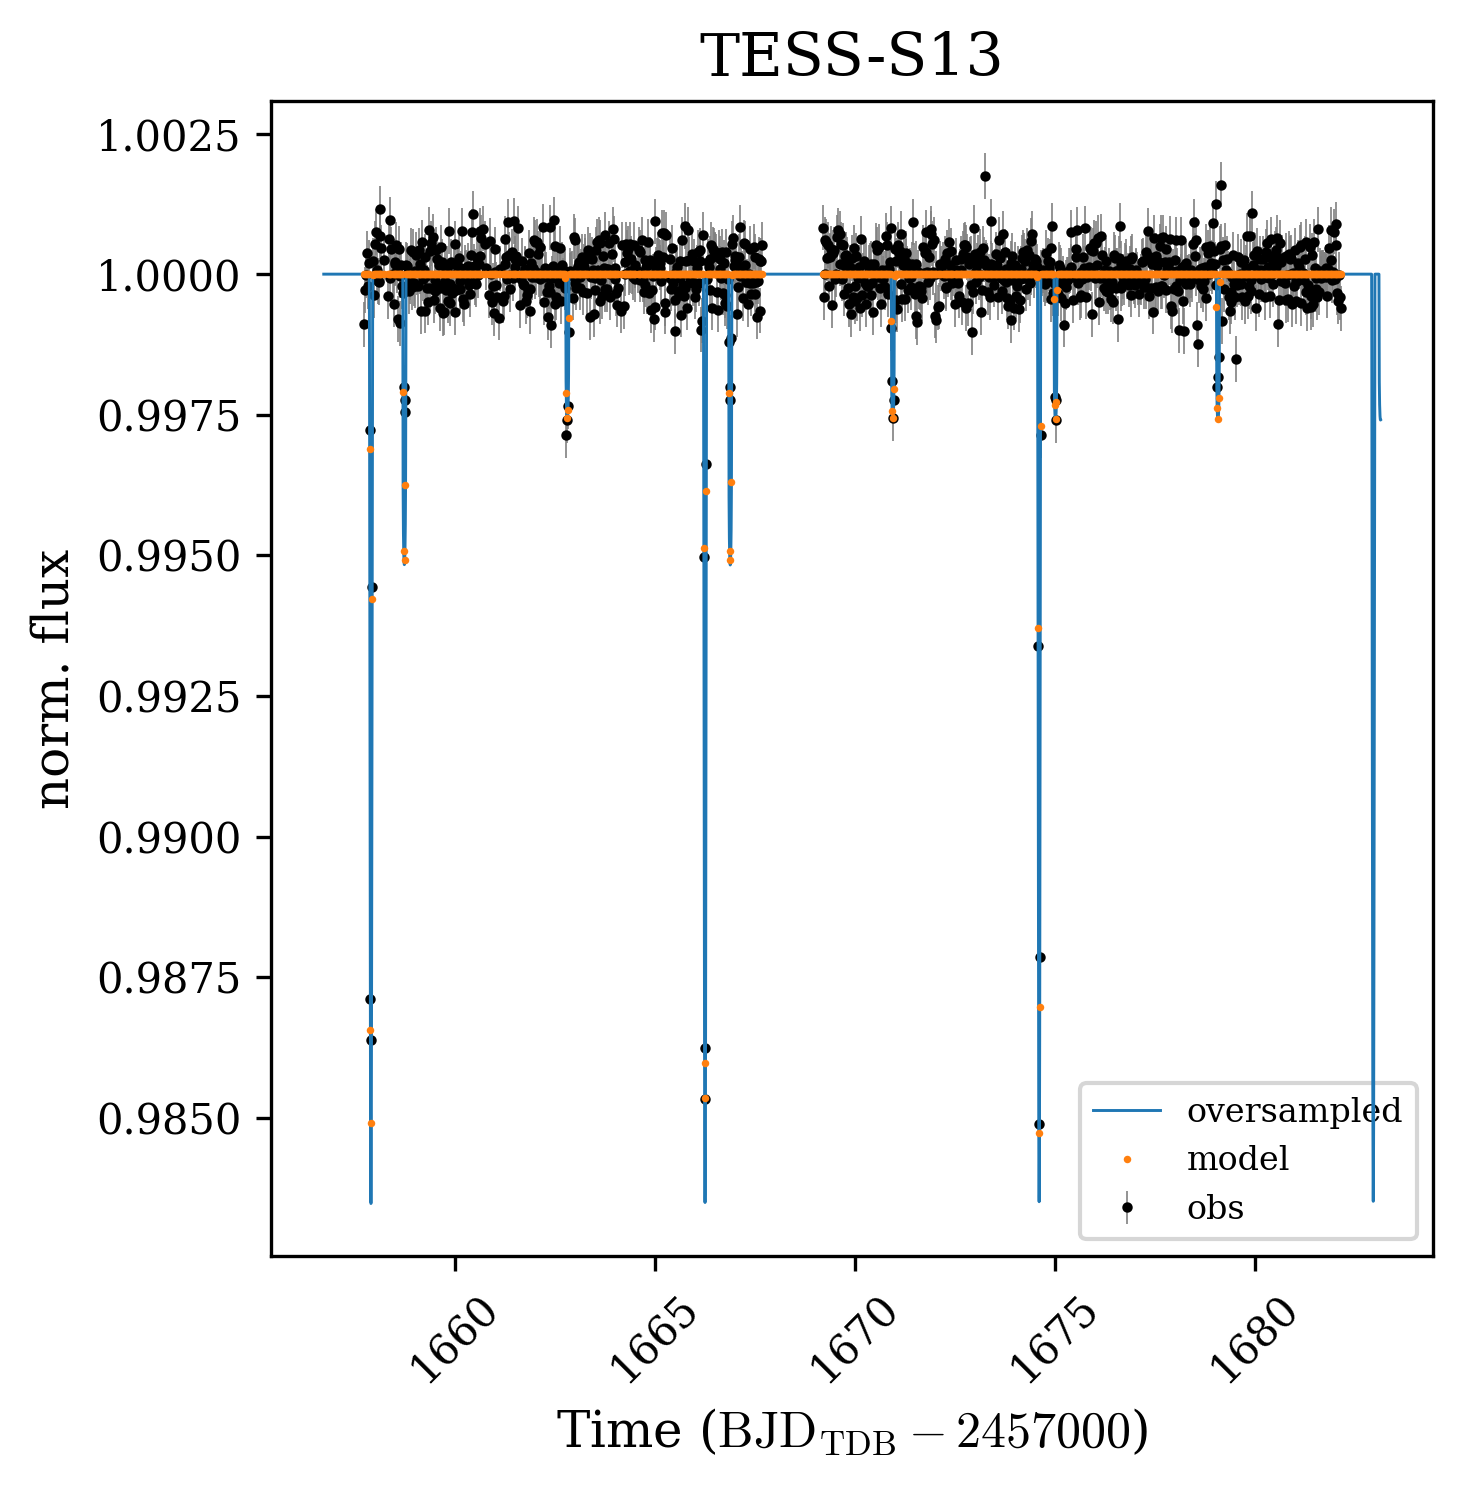

In [29]:
fig = plt.figure()

plt.title("TESS-S13")

# Here we plot the OG TESS data set
plt.errorbar(
    time_s13, flux_sap_s13,
    yerr=flux_sap_err_s13,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

# Here we plot the oversampled model (the one that fills in the gaps)
plt.plot(
    time_over_tess,
    flux_model_over_tess,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

# Here we plot the normal model (the one that doesn't fill in the gaps).
plt.plot(
    time_s13,
    flux_model_tess,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)

In [30]:
# Exact same procedure from above but with the first CHEOPS data set

flux_model_cheops_b = compute_single_flux_pytransit(
    tm, 
    time_cheops_b, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

# just to have a full model (oversampled) and covering the gaps
texpover = 60*cst.sec2day
time_over_cheops_b = np.arange(time_cheops_b.min()-0.25, time_cheops_b.max()+0.25, texpover)
flux_model_over_cheops_b = compute_single_flux_pytransit(
    tm,
    time_over_cheops_b,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

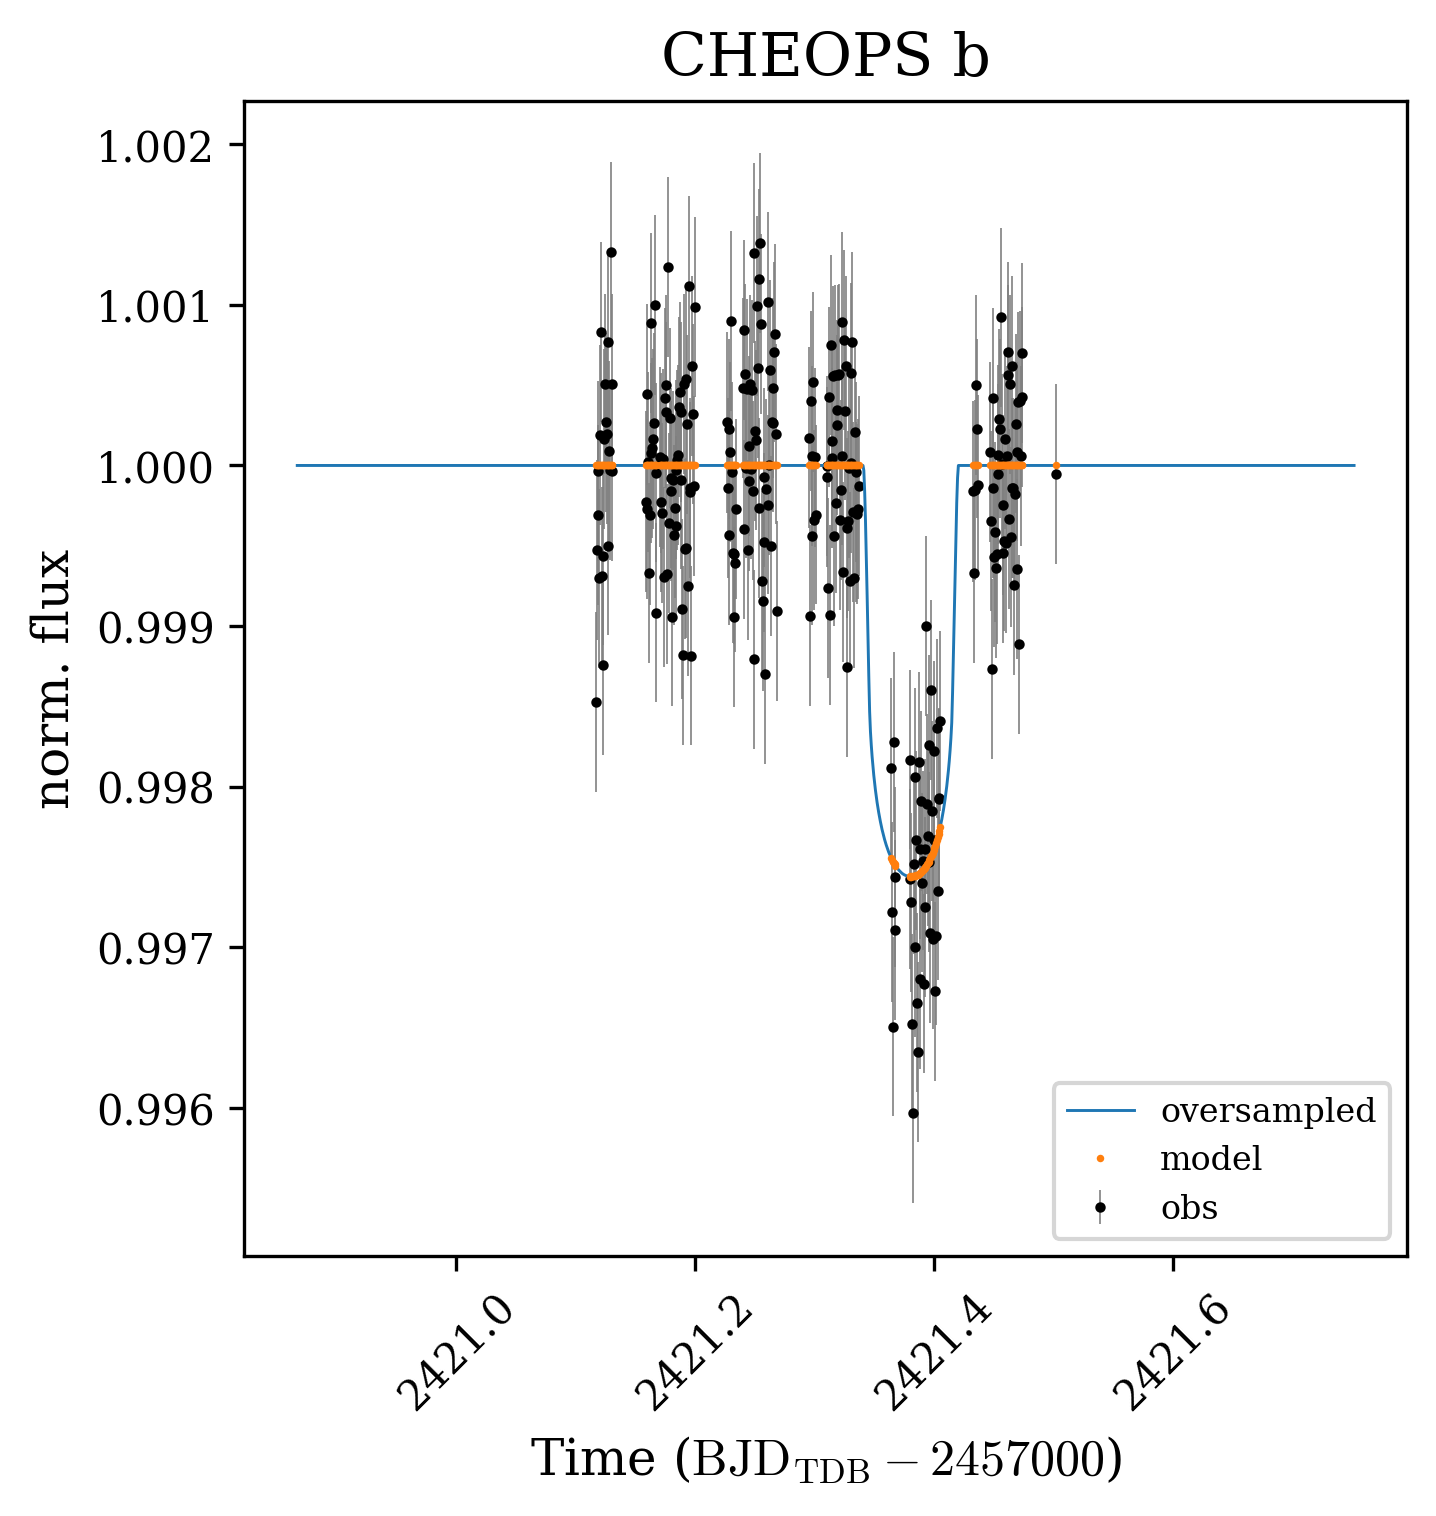

In [31]:
fig = plt.figure()

plt.title("CHEOPS b")
plt.errorbar(
    time_cheops_b, flux_cheops_b,
    yerr=flux_cheops_err_b,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over_cheops_b,
    flux_model_over_cheops_b,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_cheops_b,
    flux_model_cheops_b,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)

In [32]:
# Exact same thing with the second CHEOPS dataset

flux_model_cheops_c = compute_single_flux_pytransit(
    tm, 
    time_cheops_c, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

# just to have a full model (oversampled) and covering the gaps
texpover = 60*cst.sec2day
time_over_cheops_c = np.arange(time_cheops_c.min()-0.25, time_cheops_c.max()+0.25, texpover)
flux_model_over_cheops_c = compute_single_flux_pytransit(
    tm,
    time_over_cheops_c,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

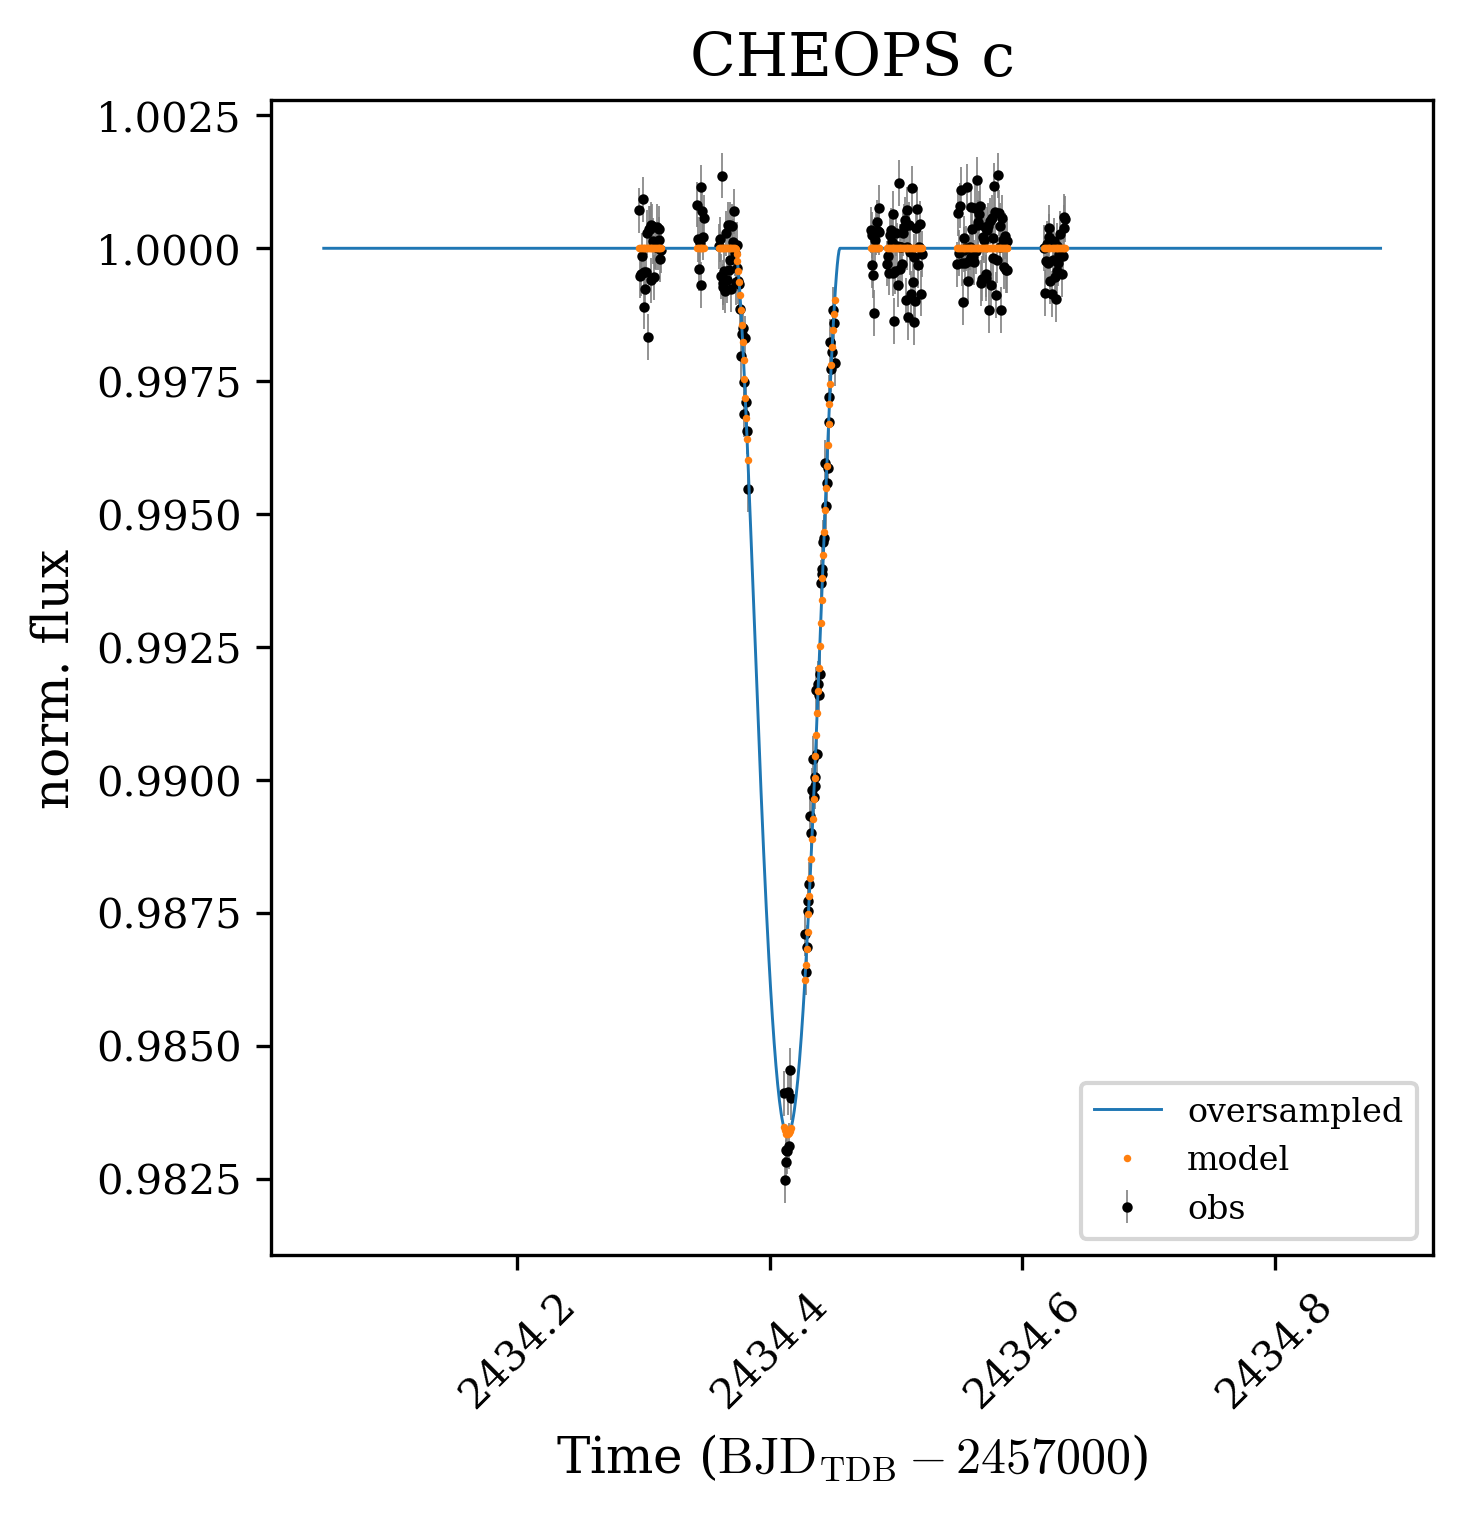

In [31]:
fig = plt.figure()

plt.title("CHEOPS c")
plt.errorbar(
    time_cheops_c, flux_cheops_c,
    yerr=flux_cheops_err_c,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over_cheops_c,
    flux_model_over_cheops_c,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_cheops_c,
    flux_model_cheops_c,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)

In [49]:
# Exact same thing with the third CHEOPS data set, the one with overlapped transits of both planets b and c

flux_model_cheops_bc = compute_single_flux_pytransit(
    tm, 
    time_cheops_bc, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

# just to have a full model (oversampled) and covering the gaps
texpover = 60*cst.sec2day
time_over_cheops_bc = np.arange(time_cheops_bc.min()-0.25, time_cheops_bc.max()+0.25, texpover)
flux_model_over_cheops_bc = compute_single_flux_pytransit(
    tm,
    time_over_cheops_bc,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

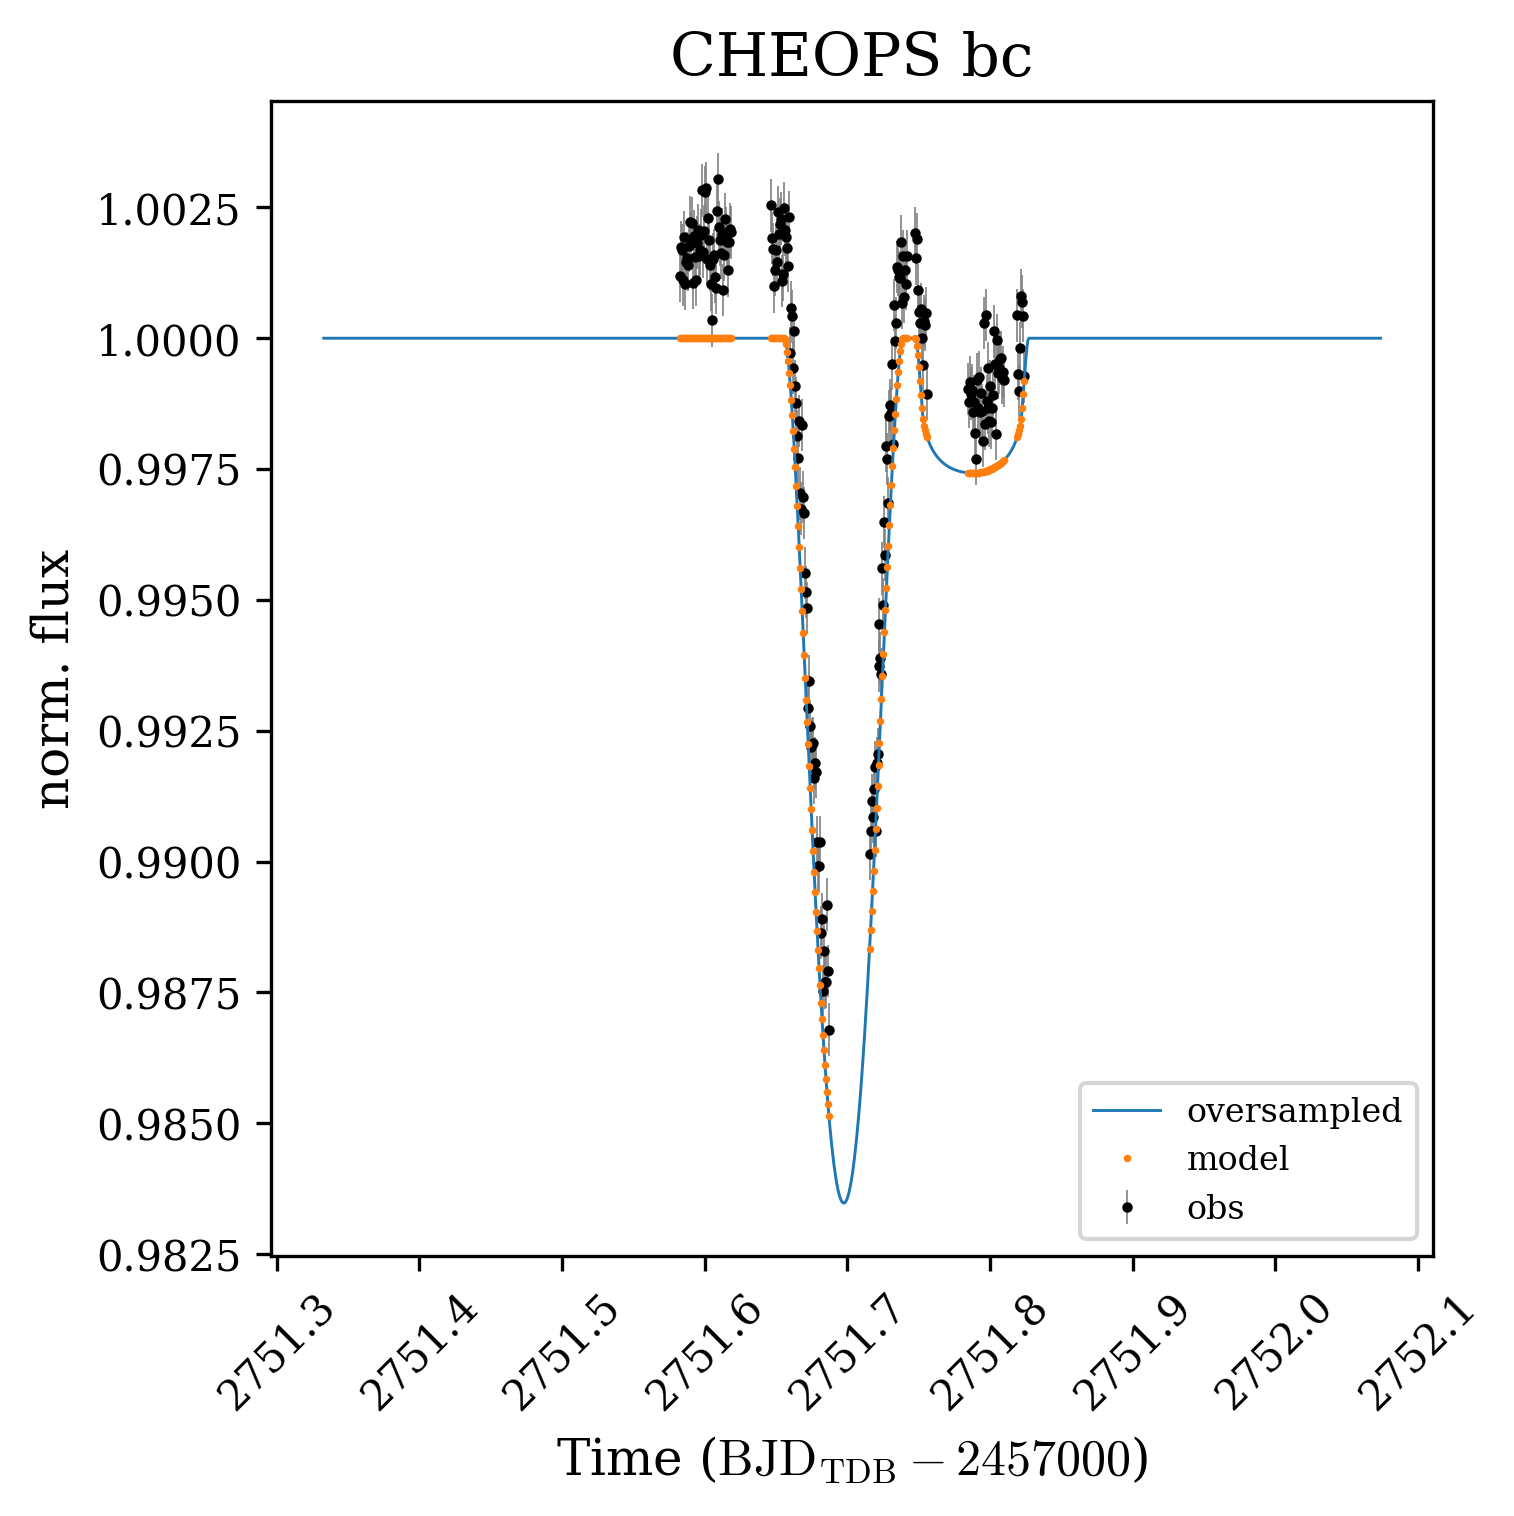

In [50]:
fig = plt.figure()

plt.title("CHEOPS bc")
plt.errorbar(
    time_cheops_bc, flux_cheops_bc,
    yerr=flux_cheops_err_bc,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over_cheops_bc,
    flux_model_over_cheops_bc,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_cheops_bc,
    flux_model_cheops_bc,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)